In [1]:
import warnings
import numpy as np
from tvolib import mpl_utils as mu

from rls.models import WhistlerAtHyperbolicGradientModel

warnings.filterwarnings("ignore")


def plot_model(model):
    c = model.units.c.code
    R = model.R.code
    Bw = model.Bw.code
    B0 = model.B0.code
    Tce0 = model.units.electron.Tc(model.B0).code
    x = np.linspace(-3, 3, 1000) * R * 0.4
    z = np.linspace(-3, 3, 2000) * R
    X, Z = np.meshgrid(x, z, indexing="ij")
    Y = np.zeros_like(X)

    # Calculate dispersion relation & wave field
    _, _, _, B0_x, _, B0_z = model.background_field(
        0.0, X, Y, Z, *model.background_field_args
    )
    Ew_x, Ew_y, Ew_z, Bw_x, Bw_y, Bw_z = model.wave_field(
        0.0, X, Y, Z, B0_x, B0_z, *model.wave_field_args
    )
    B0_mag = np.sqrt(B0_x**2 + B0_z**2)
    
    # Calculate normal angles
    Ew_mag = np.sqrt(Ew_x ** 2 + Ew_y ** 2 + Ew_z ** 2)
    Bw_mag = np.sqrt(Bw_x ** 2 + Bw_y ** 2 + Bw_z ** 2)
    S_x = Ew_y * Bw_z - Ew_z * Bw_y
    S_y = Ew_z * Bw_x - Ew_x * Bw_z
    S_z = Ew_x * Bw_y - Ew_y * Bw_x
    S_mag = np.sqrt(S_x ** 2 + S_y ** 2 + S_z ** 2)
    E_angle = np.degrees(np.arccos((Ew_x * B0_x + Ew_z * B0_z) / Ew_mag / B0_mag))
    B_angle = np.degrees(np.arccos((Bw_x * B0_x + Bw_z * B0_z) / Bw_mag / B0_mag))
    S_angle = np.degrees(np.arccos((S_x * B0_x + S_z * B0_z) / S_mag / B0_mag))
    EB_angle = np.degrees(np.arccos((Ew_x * Bw_x + Ew_y * Bw_y + Bw_z * Bw_z) / Ew_mag / Bw_mag))

    # ---- Plot wave components
    fig, axes = mu.plt.subplots(6, 1, figsize=(12, 14), sharex=True)
    fig.suptitle("Wave components")
    skw = dict(color="k", density=0.5, linewidth=0.2 * B0_mag / B0_mag.min())
    kw = dict(cmap="seismic")
    
    cax = mu.add_colorbar(ax := axes[0])
    im = ax.pcolormesh(Z / R, X / R, Bw_x / Bw, vmin=-1, vmax=1, **kw)
    cb = fig.colorbar(im, cax=cax)
    cb.set_label("$B_{wx}/B_{w0}$")
    
    cax = mu.add_colorbar(ax := axes[1])
    im = ax.pcolormesh(Z / R, X / R, Bw_y / Bw, vmin=-1, vmax=1, **kw)
    cb = fig.colorbar(im, cax=cax)
    cb.set_label("$B_{wy}/B_{w0}$")
    
    cax = mu.add_colorbar(ax := axes[2])
    im = ax.pcolormesh(Z / R, X / R, Bw_z / Bw, vmin=-1, vmax=1, **kw)
    cb = fig.colorbar(im, cax=cax)
    cb.set_label("$B_{wz}/B_{w0}$")
    
    cax = mu.add_colorbar(ax := axes[3])
    im = ax.pcolormesh(Z / R, X / R, Ew_x / (c * Bw), **kw)
    cb = fig.colorbar(im, cax=cax)
    cb.set_label("$E_{wx}/cB_{w0}$")

    cax = mu.add_colorbar(ax := axes[4])
    im = ax.pcolormesh(Z / R, X / R, Ew_y / (c * Bw), **kw)
    cb = fig.colorbar(im, cax=cax)
    cb.set_label("$E_{wy}/cB_{w0}$")
    
    cax = mu.add_colorbar(ax := axes[5])
    im = ax.pcolormesh(Z / R, X / R, Ew_z / (c * Bw), **kw)
    cb = fig.colorbar(im, cax=cax)
    cb.set_label("$E_{wz}/cB_{w0}$")

    for (i, ax) in enumerate(axes):
        ax.streamplot(Z / R, X / R, B0_z, B0_x, **skw)
        ax.set_xlim((z / R).min(), (z / R).max())
        ax.set_ylim((x / R).min(), (x / R).max())
        ax.set_ylabel("$x/R$")
        ax.set_aspect("equal")
        if i == len(axes) - 1:
            ax.set_xlabel("$z/R$")

    fig.tight_layout(h_pad=0.05)
    
    # ---- Plot normal angles
    fig, axes = mu.plt.subplots(6, 1, figsize=(12, 14), sharex=True)
    fig.suptitle("Normal angles")
    skw = dict(color="k", density=0.7, linewidth=0.5 * B0_mag / B0_mag.min())
    kw = dict(cmap="jet", vmin=0, vmax=180)
    
    cax = mu.add_colorbar(ax := axes[0])
    im = ax.pcolormesh(Z / R, X / R, Ew_mag / (c * Bw), cmap="jet")
    cb = fig.colorbar(im, cax=cax)
    cb.set_label("$|E_w|/cB_{w0}$")
    
    cax = mu.add_colorbar(ax := axes[1])
    im = ax.pcolormesh(Z / R, X / R, Bw_mag / Bw, vmin=0, vmax=1, cmap="jet")
    cb = fig.colorbar(im, cax=cax)
    cb.set_label("$|B_w|/B_{w0}$")
    
    cax = mu.add_colorbar(ax := axes[2])
    im = ax.pcolormesh(Z / R, X / R, E_angle, **kw)
    cb = fig.colorbar(im, cax=cax)
    cb.set_label("$E_w\cdot B_0$")
    
    cax = mu.add_colorbar(ax := axes[3])
    im = ax.pcolormesh(Z / R, X / R, B_angle, **kw)
    cb = fig.colorbar(im, cax=cax)
    cb.set_label("$B_w\cdot B_0$")
    
    cax = mu.add_colorbar(ax := axes[4])
    im = ax.pcolormesh(Z / R, X / R, EB_angle, **kw)
    cb = fig.colorbar(im, cax=cax)
    cb.set_label("$E_w\cdot B_w$")
    
    cax = mu.add_colorbar(ax := axes[5])
    im = ax.pcolormesh(Z / R, X / R, S_angle, **kw)
    cb = fig.colorbar(im, cax=cax)
    cb.set_label("$S\cdot B_0$")
    
    for (i, ax) in enumerate(axes):
        ax.streamplot(Z / R, X / R, B0_z / B0, B0_x / B0, **skw)
        ax.set_xlim((z / R).min(), (z / R).max())
        ax.set_ylim((x / R).min(), (x / R).max())
        ax.set_ylabel("$x/R$")
        if i == len(axes) - 1:
            ax.set_xlabel("$z/R$")
    
    fig.tight_layout(h_pad=0.05)

    # ---- Finally, we check the polarization
    t = np.linspace(0, 10 * Tce0, 1000)
    x = np.zeros_like(t)
    y = np.zeros_like(t)
    z = np.zeros_like(t)
    Ex, Ey, Ez, Bx, By, Bz = model.field(t, x, y, z, *model.field_args)

    fig, axes = mu.plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle("Polarization")

    mu.draw_multicolored_line(axes[0], Ex, Ey, t, cmap="jet", set_lim=True)
    mu.draw_multicolored_line(axes[1], Bx, By, t, cmap="jet", set_lim=True)

    axes[0].set_xlabel("$E_{wx}$")
    axes[0].set_ylabel("$E_{wy}$")
    axes[1].set_xlabel("$B_{wx}$")
    axes[1].set_ylabel("$B_{wy}$")
    for (i, ax) in enumerate(axes):
        ax.set_aspect("equal")
        ax.set_facecolor("silver")

    fig.tight_layout()
    mu.plt.show() 

# Field points to the right, rightward wave

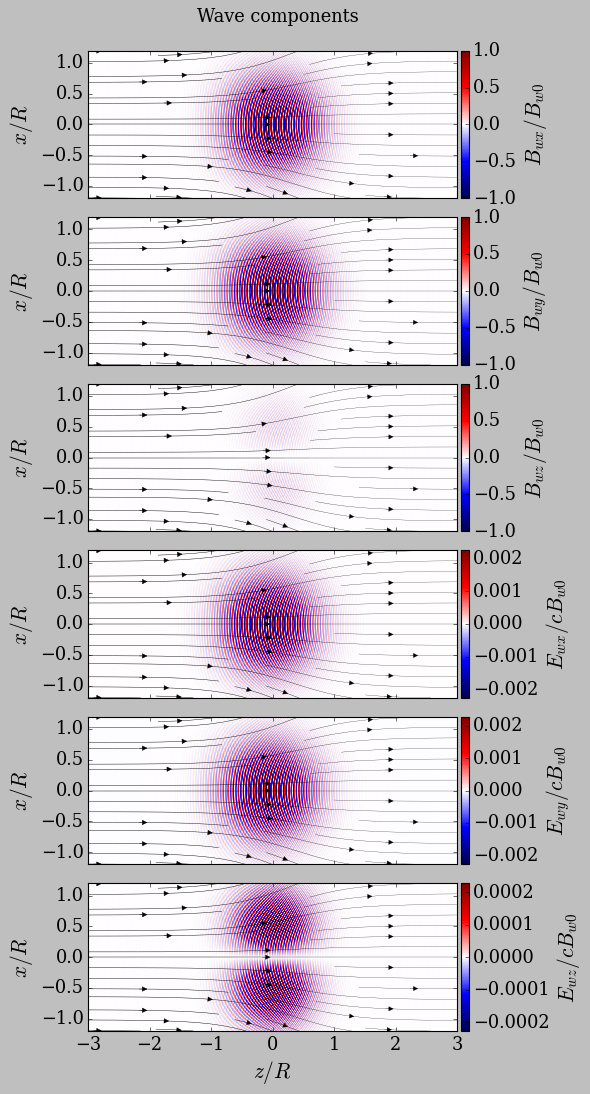

In [ ]:
kw = dict(Bw=0.05, sw=1.75, R=3.5)
plot_model(
    model=WhistlerAtHyperbolicGradientModel(
        theta=0.0,
        Bh=0.5,
        B0=1.0,
        **kw,
    )
)

# Field points to the right, leftward wave

In [ ]:
plot_model(
    model=WhistlerAtHyperbolicGradientModel(
        theta=np.pi,
        Bh=0.5,
        B0=1.0,
        **kw
    )
)

# Field points to the left, leftward wave

In [ ]:
plot_model(
    model=WhistlerAtHyperbolicGradientModel(
        theta=0.0,
        Bh=-0.5,
        B0=-1.0,
        **kw
    )
)

# Field points to the left, rightward wave

In [ ]:
plot_model(
    model=WhistlerAtHyperbolicGradientModel(
        theta=np.pi,
        Bh=-0.5,
        B0=-1.0,
        **kw
    )
)